In [1]:
# Importing Libraries
import cv2
import glob
import copy
import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import tqdm.notebook as tq
from mtcnn.mtcnn import MTCNN

In [2]:
# Initializing
detector = MTCNN()
count = 0
COUNT_IMAGE_NAME = 0
NOSE_TAKEN = False
LEFT_EYE_TAKEN = False
RIGHT_EYE_TAKEN = False
FOREHEAD_TAKEN = False
IMAGE_TAKEN = False
MOUTH_TAKEN = False
SAVE_PATH = r'MultiFer2013\training'

In [3]:
def saveImage(path,image):
    global COUNT_IMAGE_NAME
    sub_dir = save_path #+path
    Path(sub_dir).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(sub_dir+'\\'+str(COUNT_IMAGE_NAME)+'.jpg', image)
    
def resize(img):
    width = 64
    height = 64
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def removeFromAll(file_name,file):
    global NOSE_TAKEN,LEFT_EYE_TAKEN,RIGHT_EYE_TAKEN,FOREHEAD_TAKEN,IMAGE_TAKEN,MOUTH_TAKEN,COUNT_IMAGE_NAME
    if IMAGE_TAKEN:os.remove(SAVE_PATH+"0"+'\\'+file+'\\'+str(COUNT_IMAGE_NAME)+'.jpg');IMAGE_TAKEN = False
    if NOSE_TAKEN:os.remove(SAVE_PATH+"1"+'\\'+file+'\\'+str(COUNT_IMAGE_NAME)+'.jpg');NOSE_TAKEN = False
    if FOREHEAD_TAKEN:os.remove(SAVE_PATH+"5"+'\\'+file+'\\'+str(COUNT_IMAGE_NAME)+'.jpg');FOREHEAD_TAKEN = False
    if LEFT_EYE_TAKEN:os.remove(SAVE_PATH+"3"+'\\'+file+'\\'+str(COUNT_IMAGE_NAME)+'.jpg');LEFT_EYE_TAKEN = False
    if RIGHT_EYE_TAKEN:os.remove(SAVE_PATH+"4"+'\\'+file+'\\'+str(COUNT_IMAGE_NAME)+'.jpg');RIGHT_EYE_TAKEN = False
    if MOUTH_TAKEN:os.remove(SAVE_PATH+"2"+'\\'+file+'\\'+str(COUNT_IMAGE_NAME)+'.jpg');MOUTH_TAKEN = False

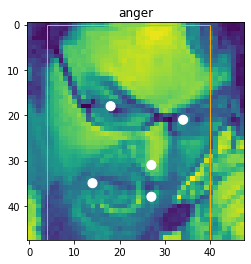

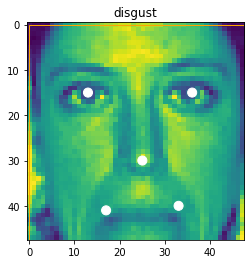

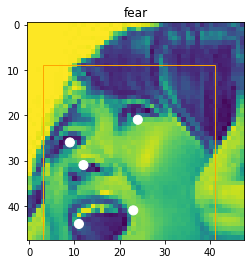

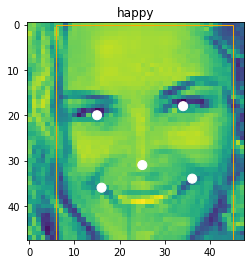

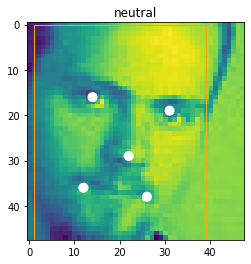

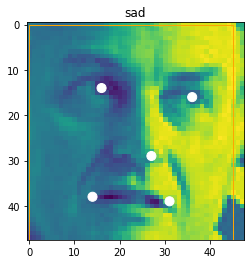

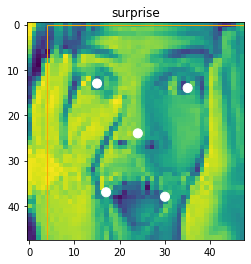

In [4]:
# Finding Key-Points using MTCNN
def draw_facebox(filename, result_list,title):
    data = plt.imread(filename)
    plt.imshow(data)
    plt.title(title)
    ax = plt.gca()
    for result in result_list:
        x, y, width, height = result['box']
        rect = plt.Rectangle((x, y), width, height,fill=False, color='orange')
        ax.add_patch(rect)
        for key, value in result['keypoints'].items():
            dot = plt.Circle(value, radius=1, color='white')
            ax.add_patch(dot)
        plt.show()

file = ["anger","disgust","fear","happy","neutral","sad","surprise"]
for i in range(len(file)):
    for image in glob.glob(r'data\Fer 2013\{}\*'.format(file[i])):
        img = cv2.imread(image)
        faces = detector.detect_faces(img)
        draw_facebox(image, faces,file[i])
        break


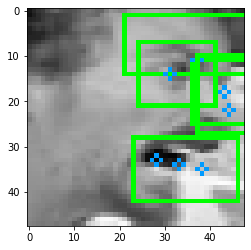

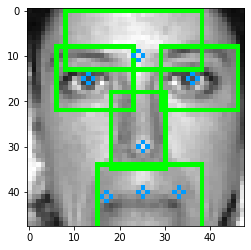

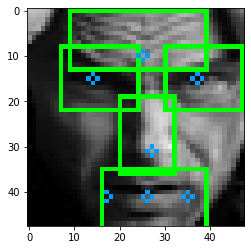

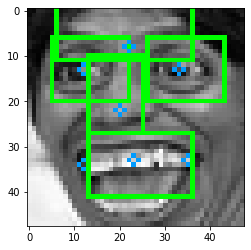

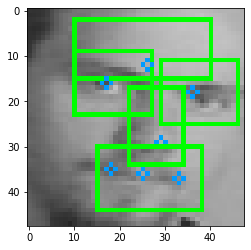

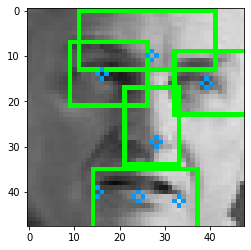

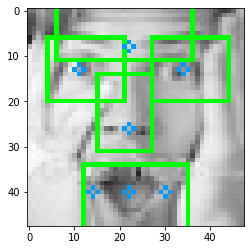

In [6]:
# Draw Rectangles Around keypoints
for file in ["anger","disgust","fear","happy","neutral","sad","surprise"]:
    global COUNT_IMAGE_NAME
    COUNT_IMAGE_NAME = 0
    plt.figure()
    for models_dir in range(6): 
        save_path = SAVE_PATH+str(models_dir)+'\\'+file
        Path(save_path).mkdir(parents=True, exist_ok=True)
    
    for image in glob.glob(r'data\FER 2013\{}\*'.format(file)):
        global NOSE_TAKEN,LEFT_EYE_TAKEN,RIGHT_EYE_TAKEN,FOREHEAD_TAKEN,IMAGE_TAKEN,MOUTH_TAKEN
        img = cv2.imread(image)
        file_name = image.split('\\')[-1]
        # plt.imshow(img)
        
        #  Resize
        scale_percent = 100 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        faces = detector.detect_faces(img)
        for face in faces:
            (x,y,w,h) = face['box']
            crop_img = img[y:y+h, x:x+w]
            img = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)
            real_img = copy.deepcopy(img)
            faces = detector.detect_faces(img)

        if faces:
            (x,y,w,h) = faces[0]['box']
            keypoints = faces[0]['keypoints']
            IMAGE_TAKEN = True

            #Manual Rectangle aroud eye
            ML = None
            doForehead = False
            for points in keypoints:
                try:
                    if points in "nose":
                        X,Y = keypoints[points];X = X-7;Y = Y-12
                        h = 12
                        w = 17
                        cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                        Nose = real_img[Y:Y+w, X:X+h]
                        NOSE_TAKEN = True

                    elif points in "mouth_left" or points in "mouth_right":
                        if ML is None:
                            ML = keypoints[points]
                        else:
                            X,Y = keypoints[points]
                            X = int((X+ML[0])/2)
                            Y = int((Y+ML[1])/2)
                            X = X-10;Y = Y-6
                            h = 23
                            w = 14
                            cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                            Mouth = real_img[Y:Y+w, X:X+h]
                            cv2.circle(img,((int((keypoints[points][0]+ML[0])/2),int((keypoints[points][1]+ML[1])/2))),1,(0,155,255),1)
                            MOUTH_TAKEN = True
                    else:
                        X,Y = keypoints[points];X = X-7;Y = Y-7
                        h = 17
                        w = 14
                        cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                        if points in "left_eye":
                            LeftEye = real_img[Y:Y+w, X:X+h]
                            LEFT_EYE_TAKEN = True
                        else:
                            RightEye = real_img[Y:Y+w, X:X+h]
                            doForehead = True
                            RIGHT_EYE_TAKEN = True

                # Manual Finding Forehead
                    if doForehead:
                        LE = list(keypoints['left_eye'])
                        RE = list(keypoints['right_eye'])
                        LE[1] = LE[1]-5
                        RE[1] = RE[1]-5
                        X,Y = LE
                        X = int((X+RE[0])/2)
                        Y = int((Y+RE[1])/2)
                        X = X-16;Y = Y-10
                        h = 30
                        w = 13
                        cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                        Forehead = real_img[Y:Y+w, X:X+h]
                        
                        FOREHEAD_TAKEN = True

                        doForehead = False
                        cv2.circle(img,((int((LE[0]+RE[0])/2),int((LE[1]+RE[1])/2))),1,(0,155,255),1)    
                        cv2.circle(img,(keypoints['left_eye']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['right_eye']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['nose']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['mouth_left']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['mouth_right']),1,(0,155,255),1)

                        FaceFeatures = [img,LeftEye,RightEye,Nose,Forehead,Mouth]
                        cv2.imshow(img)
                    
                    if (NOSE_TAKEN and LEFT_EYE_TAKEN and RIGHT_EYE_TAKEN and 
                        FOREHEAD_TAKEN and IMAGE_TAKEN and MOUTH_TAKEN):
                        COUNT_IMAGE_NAME = COUNT_IMAGE_NAME + 1
                        NOSE_TAKEN = False;LEFT_EYE_TAKEN = False
                        RIGHT_EYE_TAKEN = False;FOREHEAD_TAKEN = False
                        IMAGE_TAKEN = False;MOUTH_TAKEN = False
                    plt.imshow(img)
                except:
                    pass
            break
        else:
            count = count + 1

In [7]:
# Save each features as a different Dataset
# Actual ["anger","contempt","disgust","fear","happy","neutral","sad","surprise"]

for file in tq.tqdm(["anger","disgust","fear","happy","neutral","sad","surprise"]):
    global COUNT_IMAGE_NAME
    COUNT_IMAGE_NAME = 0
    
    for models_dir in range(6): 
        save_path = SAVE_PATH+str(models_dir)+'\\'+file
        Path(save_path).mkdir(parents=True, exist_ok=True)
    
    for image in tq.tqdm(glob.glob(r'data\FER 2013\{}\*'.format(file))):
        global NOSE_TAKEN,LEFT_EYE_TAKEN,RIGHT_EYE_TAKEN,FOREHEAD_TAKEN,IMAGE_TAKEN,MOUTH_TAKEN
        img = cv2.imread(image)
        file_name = image.split('\\')[-1]

        #  Resize
        scale_percent = 100 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        faces = detector.detect_faces(img)
        for face in faces:
            (x,y,w,h) = face['box']
            crop_img = img[y:y+h, x:x+w]
            img = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)
            real_img = copy.deepcopy(img)
            faces = detector.detect_faces(img)

        if faces:
            (x,y,w,h) = faces[0]['box']
            keypoints = faces[0]['keypoints']
            save_path = SAVE_PATH+"0"+'\\'+file
            saveImage('\\image', resize(real_img))
            IMAGE_TAKEN = True

            #Manual Rectangle aaroud eye
            ML = None
            doForehead = False
            for points in keypoints:
                try:
                    if points in "nose":
                        X,Y = keypoints[points];X = X-7;Y = Y-12
                        h = 12
                        w = 17
                        cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                        Nose = real_img[Y:Y+w, X:X+h]
                        save_path = SAVE_PATH+"1"+'\\'+file
                        saveImage('\\nose', resize(Nose))
                        NOSE_TAKEN = True

                    elif points in "mouth_left" or points in "mouth_right":
                        if ML is None:
                            ML = keypoints[points]
                        else:
                            X,Y = keypoints[points]
                            X = int((X+ML[0])/2)
                            Y = int((Y+ML[1])/2)
                            X = X-10;Y = Y-6
                            h = 21
                            w = 12
                            cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                            Mouth = real_img[Y:Y+w, X:X+h]
                            save_path = SAVE_PATH+"2"+'\\'+file
                            saveImage('\\mouth', resize(Mouth))
                            cv2.circle(img,((int((keypoints[points][0]+ML[0])/2),int((keypoints[points][1]+ML[1])/2))),1,(0,155,255),1)
                            MOUTH_TAKEN = True
                    else:
                        X,Y = keypoints[points];X = X-7;Y = Y-7
                        h = 17
                        w = 14
                        cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                        if points in "left_eye":
                            LeftEye = real_img[Y:Y+w, X:X+h]
                            save_path = SAVE_PATH+"3"+'\\'+file
                            saveImage('\\left_eye', resize(LeftEye))
                            LEFT_EYE_TAKEN = True
                        else:
                            RightEye = real_img[Y:Y+w, X:X+h]
                            save_path = SAVE_PATH+"4"+'\\'+file
                            saveImage('\\right_eye', resize(RightEye))
                            doForehead = True
                            RIGHT_EYE_TAKEN = True

                # Manual Finding Forehead
                    if doForehead:
                        LE = list(keypoints['left_eye'])
                        RE = list(keypoints['right_eye'])
                        LE[1] = LE[1]-5
                        RE[1] = RE[1]-5
                        X,Y = LE
                        X = int((X+RE[0])/2)
                        Y = int((Y+RE[1])/2)
                        X = X-14;Y = Y-7
                        h = 30
                        w = 11
                        cv2.rectangle(img,(X,Y),(X+h,Y+w),(0,255,0),thickness=1)
                        Forehead = real_img[Y:Y+w, X:X+h]
                        save_path = SAVE_PATH+"5"+'\\'+file
                        saveImage('\\forehead', resize(Forehead))
                        FOREHEAD_TAKEN = True

                        doForehead = False
                        cv2.circle(img,((int((LE[0]+RE[0])/2),int((LE[1]+RE[1])/2))),1,(0,155,255),1)    
                        cv2.circle(img,(keypoints['left_eye']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['right_eye']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['nose']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['mouth_left']),1,(0,155,255),1)
                        cv2.circle(img,(keypoints['mouth_right']),1,(0,155,255),1)

                        FaceFeatures = [img,LeftEye,RightEye,Nose,Forehead,Mouth]
                    if (NOSE_TAKEN and LEFT_EYE_TAKEN and RIGHT_EYE_TAKEN and 
                        FOREHEAD_TAKEN and IMAGE_TAKEN and MOUTH_TAKEN):
                        COUNT_IMAGE_NAME = COUNT_IMAGE_NAME + 1
                        NOSE_TAKEN = False;LEFT_EYE_TAKEN = False
                        RIGHT_EYE_TAKEN = False;FOREHEAD_TAKEN = False
                        IMAGE_TAKEN = False;MOUTH_TAKEN = False
                except:
                    removeFromAll(file_name,file)
        else:
            count = count + 1

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4953 [00:00<?, ?it/s]

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/5121 [00:00<?, ?it/s]

  0%|          | 0/8989 [00:00<?, ?it/s]

  0%|          | 0/6198 [00:00<?, ?it/s]

  0%|          | 0/6077 [00:00<?, ?it/s]

  0%|          | 0/4002 [00:00<?, ?it/s]

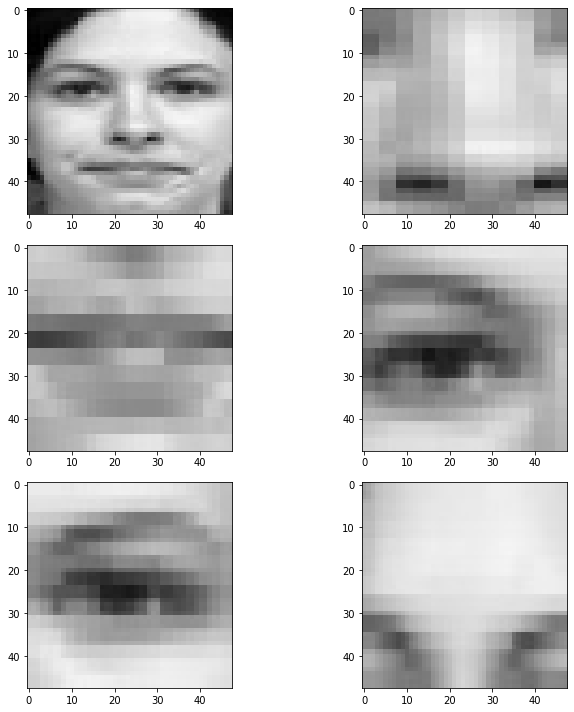

In [8]:
# Example of Dataset
import os
path = r'Dataset\multimodels'
fnames = os.listdir(path)
comb = iter([(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)])
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 10, forward=True)
def foo(path):
    for i in fnames:
        fig.tight_layout()
        X,Y = next(comb)
        newPath = path+'\\'+i
        featurenames = os.listdir(newPath)[1]
        newPath = path+'\\'+i+'\\'+featurenames
        img = plt.imread(newPath+'\\'+os.listdir(newPath)[0])
        axs[X, Y].imshow(img)
        
foo(path)

### Split Dataset

In [9]:
import splitfolders

for i in range(6):
    input_folder = r"MultiFer2013\training{}".format(i)
    output = r"FinalMultiFer2013\Dataset{}".format(i)
    splitfolders.ratio(input_folder, output=output, seed=1, ratio=(.8, .2,)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 22329 files [02:37, 141.95 files/s]
Copying files: 22329 files [02:43, 136.33 files/s]
Copying files: 22329 files [02:36, 142.37 files/s]
Copying files: 22329 files [02:39, 139.74 files/s]
Copying files: 22329 files [02:43, 136.83 files/s]
Copying files: 22329 files [02:42, 137.75 files/s]
